In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from tqdm import tqdm

#!pip freeze | grep 'matplotlib\|^numpy\|pandas\|seaborn\|tensorflow\|tqdm\|ipython-autotime\|watermark' > requirements.txt

sns.set()
tf.enable_eager_execution()
tf.set_random_seed(1867)

%matplotlib inline
%load_ext autotime
%load_ext watermark

#### Prepare MNIST Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train/255, tf.float32),
    tf.cast(y_train, tf.int64)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test/255, tf.float32),
    tf.cast(y_test, tf.int64)
)).batch(64)

time: 4.16 s


#### Model Definition

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False),
    tf.keras.layers.Dense(10, use_bias=False)
])

time: 21 ms


#### Train Model

In [4]:
optimizer = tf.train.AdamOptimizer()
global_step = tf.train.get_or_create_global_step()

training_losses = []
training_accuracies = []

for epoch in range(10):
    epoch_loss_avg = tf.contrib.eager.metrics.Mean()
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
    for x, y in tqdm(dataset_train, total=round(len(x_train)/64)):
        with tf.GradientTape() as tape:
            outputs = model(x)
            loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights), global_step)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    training_losses.append(epoch_loss_avg.result())
    training_accuracies.append(epoch_accuracy.result())

100%|██████████| 938/938 [00:12<00:00, 72.46it/s]

time: 2min 15s


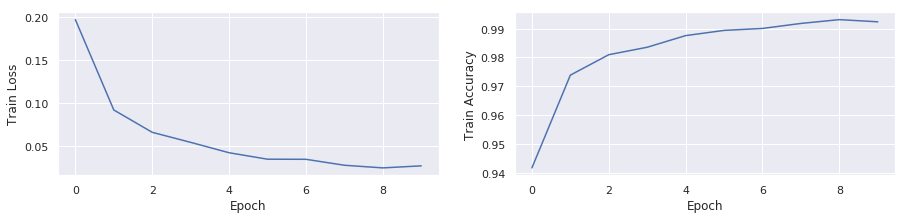

time: 273 ms


In [5]:
# Plot training curves
plt.figure(1, figsize=(15,3))
plt.subplot(121)
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.subplot(122)
plt.plot(training_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy');

In [6]:
def test(model, dataset):
    epoch_loss_avg = tf.contrib.eager.metrics.Mean()
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
    for x, y in dataset:
        outputs = model(x)
        loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    return epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()

test(model, dataset_test)

(0.10831883247318595, 0.9796)

time: 1.25 s


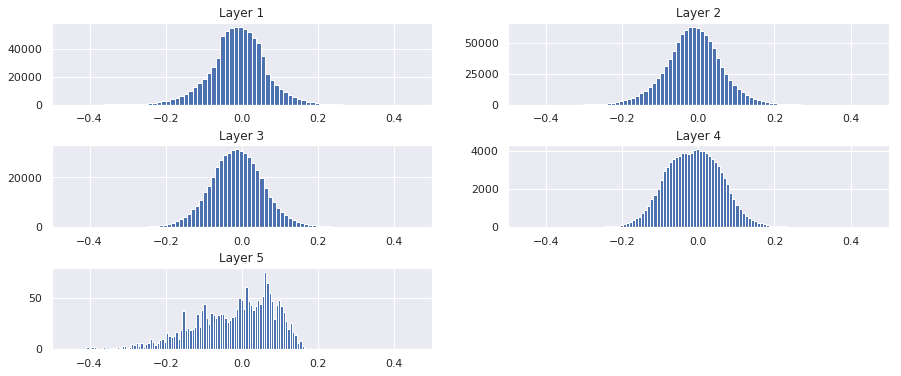

time: 1.39 s


In [7]:
# Plot histogram of each layer's weights (for weight pruning)
plt.figure(1, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(weights.numpy().reshape(-1), bins=100)
    plt.xlim(-0.5, 0.5);

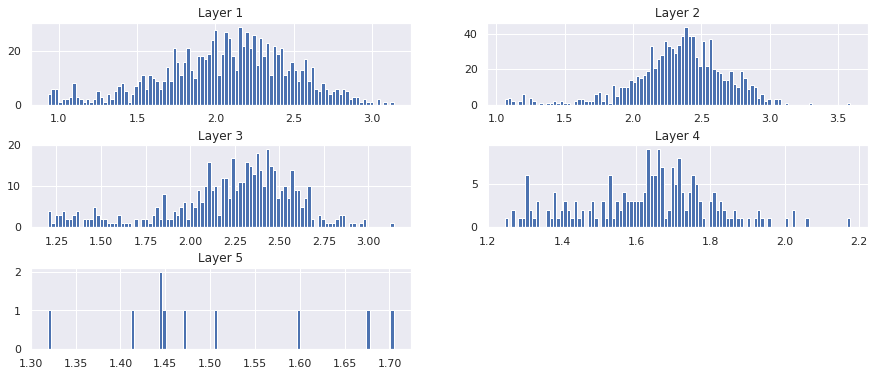

time: 1.7 s


In [8]:
# Plot histogram of each layer's coloumn norms (for unit pruning)
plt.figure(2, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    column_norms = np.linalg.norm(weights.numpy(), ord=2, axis=0)
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(column_norms, bins=100);

#### Weight Pruning

In [9]:
percentiles = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

time: 1.06 ms


In [10]:
class WeightSparseModel():
    def __init__(self, sparsify=True):
        self.sparsify = sparsify
        self.flatten = tf.layers.Flatten()
        self.weights = []
        
    def add_layer(self, weights):
        if self.sparsify:
            weights = tf.contrib.layers.dense_to_sparse(weights)
        self.weights.append(weights)
        
    def __call__(self, dense_x):
        dense_x = self.flatten(dense_x)
        # Sparse matrix multiplication requires the sparse matrix
        # to be the left operand. As such, we reorder operations
        # when sparsified:
        # relu(X x sL1) x sL2 == (sL2^T x relu(sL1^T x X^T))^T
        if self.sparsify:
            dense_x = tf.transpose(dense_x) # X^T
        for i, weights in enumerate(self.weights):
            if self.sparsify:
                dense_x = tf.sparse.matmul(weights, dense_x, adjoint_a=True) # sL^T x X^T
            else:
                dense_x = tf.matmul(dense_x, weights)
            # Apply ReLU to hidden outputs only
            if i < len(self.weights)-1:
                dense_x = tf.nn.relu(dense_x)
        if self.sparsify:
            dense_x = tf.transpose(dense_x) # X == (X^T)^T
        return dense_x

def prune_weights(dense_model, percentile, sparsify=True):
    sparse_model = WeightSparseModel(sparsify)
    num_layers = len(dense_model.trainable_weights)

    for i_layer, weights in enumerate(dense_model.trainable_weights):
        weights_np = weights.numpy()
        
        # Zero out pruned weights
        if i_layer < num_layers-1: # Do not prune last layer
            critical_value = np.percentile(np.abs(weights_np), percentile)
            zero_mask = np.abs(weights_np) < critical_value
            weights_np[zero_mask] = 0
        # Add new layer to sparse model
        sparse_model.add_layer(tf.convert_to_tensor(weights_np))

    return sparse_model

test(prune_weights(model, 90), dataset_test) # Sanity check

(0.7768576069242635, 0.9608)

time: 1.44 s


In [11]:
pruned_weight_test_losses = []
pruned_weight_test_accuracies = []
pruned_weight_sparse_timings = []
pruned_weight_timings = []

for percentile in percentiles:
    sparsified_model = prune_weights(model, percentile, True)
    t1 = time.clock()
    l, a = test(sparsified_model, dataset_test)
    t1 = time.clock() - t1

    pruned_model = prune_weights(model, percentile, False)
    t2 = time.clock()
    l2, a2 = test(pruned_model, dataset_test)
    t2 = time.clock() - t2
    
    # Sanity check - both weight pruning methods return same results
    np.testing.assert_almost_equal(l, l2)
    np.testing.assert_almost_equal(a, a2)
    
    print(f"Pruning p{percentile} -- Test Loss: {l:.4f}, Test Accuracy: {a:.4f}, Sparse Timing Ratio: {(t1/t2):.2f} ({t1:.2f}s/{t2:.2f}s)")
    pruned_weight_test_losses.append(l)
    pruned_weight_test_accuracies.append(a)
    pruned_weight_sparse_timings.append(t1)
    pruned_weight_timings.append(t2)

Pruning p0 -- Test Loss: 0.1083, Test Accuracy: 0.9796, Sparse Timing Ratio: 0.99 (1.60s/1.61s)
Pruning p25 -- Test Loss: 0.1064, Test Accuracy: 0.9803, Sparse Timing Ratio: 0.99 (1.59s/1.60s)
Pruning p50 -- Test Loss: 0.0939, Test Accuracy: 0.9802, Sparse Timing Ratio: 0.87 (1.46s/1.68s)
Pruning p60 -- Test Loss: 0.0859, Test Accuracy: 0.9803, Sparse Timing Ratio: 0.87 (1.44s/1.65s)
Pruning p70 -- Test Loss: 0.0872, Test Accuracy: 0.9793, Sparse Timing Ratio: 0.91 (1.45s/1.59s)
Pruning p80 -- Test Loss: 0.1485, Test Accuracy: 0.9766, Sparse Timing Ratio: 0.86 (1.41s/1.63s)
Pruning p90 -- Test Loss: 0.7769, Test Accuracy: 0.9608, Sparse Timing Ratio: 0.83 (1.34s/1.62s)
Pruning p95 -- Test Loss: 1.8271, Test Accuracy: 0.8494, Sparse Timing Ratio: 0.76 (1.35s/1.77s)
Pruning p97 -- Test Loss: 2.1518, Test Accuracy: 0.6411, Sparse Timing Ratio: 0.81 (1.35s/1.67s)
Pruning p99 -- Test Loss: 2.2948, Test Accuracy: 0.1271, Sparse Timing Ratio: 0.79 (1.32s/1.66s)
time: 33.2 s


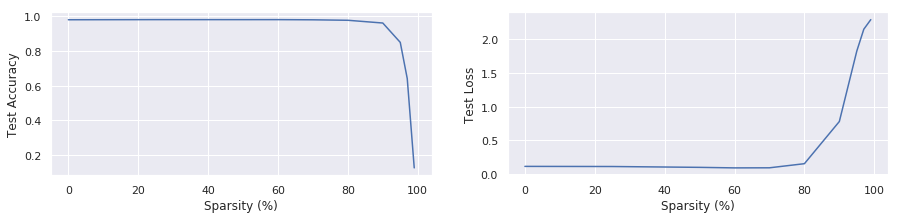

time: 303 ms


In [12]:
plt.figure(3, figsize=(15,3))
plt.subplot(121)
plt.plot(percentiles, pruned_weight_test_accuracies)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.subplot(122)
plt.plot(percentiles, pruned_weight_test_losses)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Loss');

#### Unit Pruning

In [13]:
def unit_prune(dense_model, percentile):
    prev_kept_columns = None
    pruned_model = tf.keras.models.Sequential()
    pruned_model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    num_layers = len(dense_model.trainable_weights)

    for i_layer, weights in enumerate(dense_model.trainable_weights):
        weights_np = weights.numpy()
        
        # Remove pruned columns
        if i_layer < num_layers-1: # Do not prune last layer
            column_norms = np.linalg.norm(weights_np, ord=2, axis=0)
            critical_value = np.percentile(column_norms, percentile)
            keep_mask = column_norms >= critical_value
            weights_np = weights_np[:, keep_mask]
            
        # Remove rows corresponding to previous layer's pruned columns
        if prev_kept_columns is not None:
            weights_np = weights_np[prev_kept_columns, :]
        
        # Record which columns were kept
        if i_layer < num_layers-1: # No pruned columns in last layer
            prev_kept_columns = np.argwhere(keep_mask).reshape(-1)
        
        # Add new layer to sparse model
        new_layer = tf.keras.layers.Dense(weights_np.shape[1], activation=tf.nn.relu, use_bias=False)
        pruned_model.add(new_layer)
        new_layer.set_weights([weights_np])

    return pruned_model

test(unit_prune(model, 90), dataset_test) # Sanity check

(2.2797745731985493, 0.3715)

time: 1.18 s


In [14]:
pruned_unit_test_losses = []
pruned_unit_test_accuracies = []
pruned_unit_timings = []

for percentile in percentiles:
    sparse_model = unit_prune(model, percentile)
    t = time.clock()
    l, a = test(sparse_model, dataset_test)
    t = time.clock() - t
    print(f"Pruning p{percentile} -- Test Loss: {l:.4f}, Test Accuracy: {a:.4f}, Timing: {t:.2f}s")
    pruned_unit_test_losses.append(l)
    pruned_unit_test_accuracies.append(a)
    pruned_unit_timings.append(t)

Pruning p0 -- Test Loss: 0.1050, Test Accuracy: 0.9796, Timing: 1.46s
Pruning p25 -- Test Loss: 0.0950, Test Accuracy: 0.9805, Timing: 1.43s
Pruning p50 -- Test Loss: 0.1123, Test Accuracy: 0.9790, Timing: 1.49s
Pruning p60 -- Test Loss: 0.2246, Test Accuracy: 0.9763, Timing: 1.41s
Pruning p70 -- Test Loss: 0.5606, Test Accuracy: 0.9688, Timing: 1.37s
Pruning p80 -- Test Loss: 1.7034, Test Accuracy: 0.6920, Timing: 1.43s
Pruning p90 -- Test Loss: 2.2798, Test Accuracy: 0.3715, Timing: 1.40s
Pruning p95 -- Test Loss: 2.3002, Test Accuracy: 0.1235, Timing: 1.44s
Pruning p97 -- Test Loss: 2.3025, Test Accuracy: 0.1133, Timing: 1.45s
Pruning p99 -- Test Loss: 2.3026, Test Accuracy: 0.0980, Timing: 1.39s
time: 11 s


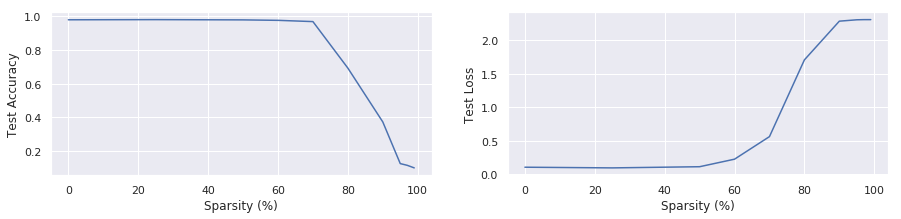

time: 307 ms


In [15]:
plt.figure(4, figsize=(15,3))
plt.subplot(121)
plt.plot(percentiles, pruned_unit_test_accuracies)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.subplot(122)
plt.plot(percentiles, pruned_unit_test_losses)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Loss');

#### Summary of Results

In [16]:
pd.options.display.float_format = '{:.4f}'.format
pd.DataFrame(data={
    'Percent Sparsity':percentiles,
    'Test Accuracy (Unit Pruned)': pruned_unit_test_accuracies,
    'Test Accuracy (Weight Pruned)': pruned_weight_test_accuracies    
})

,Percent Sparsity,Test Accuracy (Unit Pruned),Test Accuracy (Weight Pruned)
0,0,0.9796,0.9796
1,25,0.9805,0.9803
2,50,0.9790,0.9802
3,60,0.9763,0.9803
4,70,0.9688,0.9793
5,80,0.6920,0.9766
6,90,0.3715,0.9608
7,95,0.1235,0.8494
8,97,0.1133,0.6411
9,99,0.0980,0.1271


time: 27.6 ms


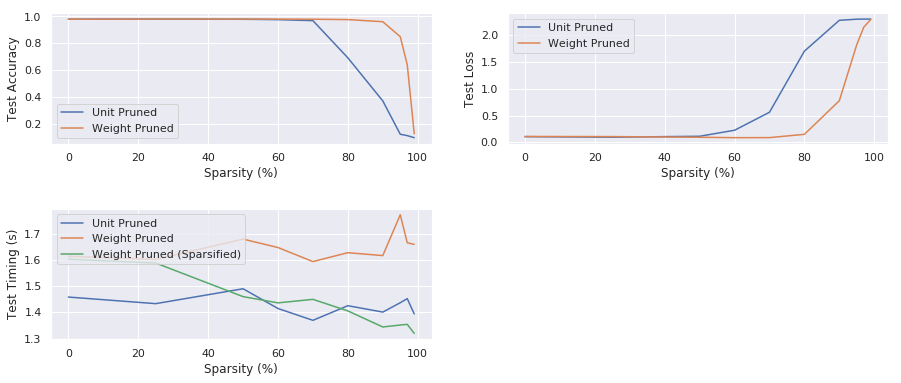

time: 514 ms


In [17]:
plt.figure(5, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
plt.subplot(221)
plt.plot(percentiles, pruned_unit_test_accuracies, label='Unit Pruned')
plt.plot(percentiles, pruned_weight_test_accuracies, label='Weight Pruned')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower left')
plt.subplot(222)
plt.plot(percentiles, pruned_unit_test_losses, label='Unit Pruned')
plt.plot(percentiles, pruned_weight_test_losses, label='Weight Pruned')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Loss')
plt.legend(loc='upper left')
plt.subplot(223)
plt.plot(percentiles, pruned_unit_timings, label='Unit Pruned')
plt.plot(percentiles, pruned_weight_timings, label='Weight Pruned')
plt.plot(percentiles, pruned_weight_sparse_timings, label='Weight Pruned (Sparsified)')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Timing (s)')
plt.legend(loc='upper left');

#### Analysis
We can observe that both pruning strategies are able to remove a large proportion of the network weights with minimal impact to classification performance. We only start to see performance impact at 70% sparsity for unit pruning, and 90% sparsity for weight pruning. Interestingly, unit pruning suffers a serious decline in performance between 70% and 95% sparsity, whereas weight pruning only runs into a similar decline in performance between 90% and 99% sparsity. At 99% sparsity (the maximum tested), both unit pruning and weight pruning perform at the level of random selection (~10% accuracy).

For lower sparsity percentages (< 50%) unit pruning appears to be more computationally efficient, as we always deal with dense matrices (and smaller ones with more pruning). At higher sparsity percentages howevever, weight pruning with sparsification (using sparse matrices and operations for weights) seems to be roughly in line with unit pruning performance, if not better at the highest sparsities. Both methods provide upto a 20% speedup over just using dense matrix operations on the full model.

In Figure 1 we see that the weights of the model (barring those in the final layer) are normally distributed, with most of the weights being centered around 0. Thus when weight pruning, the vast majority of weights are of low magnitude and can be removed with minimal impact to performance. In contrast, Figure 2 shows that the column norms of the weights are far more spread out, and not centered around 0 (by definition of the L2 norm). If we view the individual weights in a column as being independent draws from the normal distribution for that layer (maybe not a valid assumption), then the L2 column norms would follow a chi-distribution (which seems in-line with the histograms actually). When pruning columns, it's unlikely that a column is filled with many high-magnitude weights; it's more common for there to be a mixture of low and high magnitude weights. Thus, when unit pruning we risk deleting columns with individually important weights, because the rest of the column is low-magnitude and deemed unimportant. It is possible that this is what causes unit pruning's earlier decline in performance.

##### Future Directions
One recent paper in the area of model compression which I found very convincing was [The Lottery Ticket Hypothesis](https://arxiv.org/abs/1803.03635), which postulated that most of the predictive performance of large neural networks was attributable to smaller subnetworks which were initialized with good starting weights. These subnetworks could be recovered after training and weight pruning the large network; re-initialization and re-training the preserved subnetworks then leads to much faster convergence and possibly better test accuracies than the originally trained model.

#### Notebook Runtime Info

In [18]:
%watermark -i -u -v -iv -w -m -p matplotlib,tqdm

numpy       1.15.4
pandas      0.23.4
seaborn     0.9.0
tensorflow  1.12.0
last updated: 2018-11-14T02:59:41+00:00

CPython 3.6.7
IPython 7.1.1

matplotlib 2.1.0
tqdm 4.28.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-137-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
watermark 1.7.0
time: 44.1 ms
